In [15]:


import glob
import os
import warnings
import mlflow
import mlflow.pytorch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import Markdown, display
 
 

# Import functions from the module
import importlib
import _0_definitions
#import _1_visuals_script
import _01_load_data
# Reload the module to apply the changes to the script
importlib.reload(_0_definitions)
# importlib.reload(_1_visuals_script)
importlib.reload(_01_load_data)
# import  _1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
# from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
```
# import  01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(_0_definitions)
# importlib.reload(_1_visuals_script)
importlib.reload(_01_load_data)
# import  _1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
# from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [16]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())
    ### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_run_definitions.py") as file:
    exec(file.read())

In [17]:
# loading data
file_names = ["train_df_3_cat.csv", "test_df_3_cat.csv"]
# Load the data from the CSV files
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
# Unpack the dataframes into separate variables
train_df, test_df = dataframes

print("DataFrames have been loaded successfully.")


DataFrames have been loaded successfully.


In [18]:
# Defining small sample vs. end smaple
whole_data_set = False
# end sample or small sample    
if whole_data_set == True:
    print("Using the whole data set")
else:
    train_df = train_df.sample(n=100, random_state=RSEED)
    display(Markdown('<span style="color:red"> this is a small sample : 48692</span>'))

<span style="color:red"> this is a small sample : 48692</span>

new code l

In [19]:
train_df

,study_id,severity,condition,level,series_id,x,y,image_path,missing_image
1935,684747623,2.0,0,l5/s1,3.273038e+09,370.053272,506.149133,data/train_images_origin/684747623/774494956/7...,False
6494,2325650566,1.0,0,l5/s1,2.076691e+09,293.720819,472.222032,data/train_images_origin/2325650566/20477869/5...,False
1720,624881903,2.0,0,l5/s1,1.233162e+09,375.776524,475.359848,data/train_images_origin/624881903/1233161684/...,False
9120,3221995449,1.0,0,l5/s1,2.156977e+08,231.017145,348.249377,data/train_images_origin/3221995449/215697714/...,False
360,117720278,0.0,0,l5/s1,4.077719e+09,250.755900,308.758838,data/train_images_origin/117720278/2514759683/...,False
...,...,...,...,...,...,...,...,...,...
2019,701848105,2.0,0,l5/s1,3.312375e+09,265.501177,347.109288,data/train_images_origin/701848105/759243276/1...,False
9836,3473524025,0.0,0,l5/s1,7.462082e+08,158.934938,201.354724,data/train_images_origin/3473524025/1697065269...,False
11351,4030506789,0.0,0,l5/s1,2.829807e+09,262.626703,316.686648,data/train_images_origin/4030506789/2653665985...,False
6702,2383836357,0.0,0,l5/s1,2.176104e+08,177.032086,242.310160,data/train_images_origin/2383836357/217610363/...,False


Epoch [1/10], Train Loss: 236832.5346, Validation Loss: 20342.2826
Epoch [2/10], Train Loss: 80783.5347, Validation Loss: 101216.2031
Epoch [3/10], Train Loss: 94315.6043, Validation Loss: 101245.4870
Early stopping at epoch 4 due to validation loss divergence.


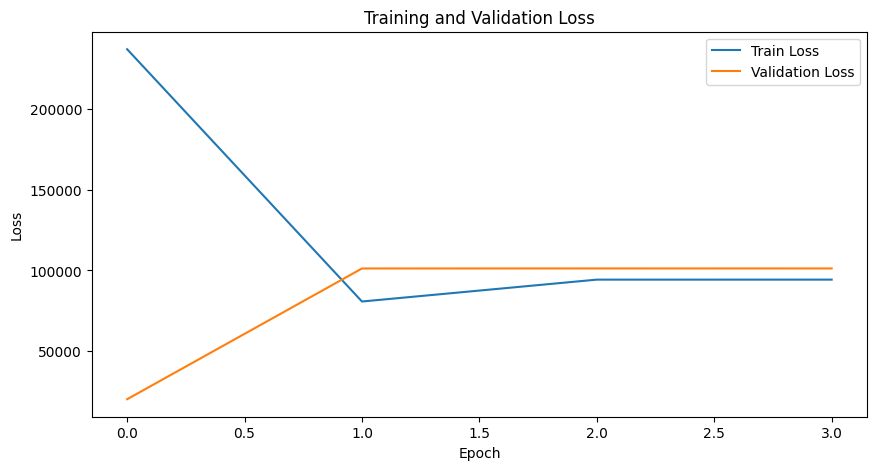

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom
import torch.nn.functional as F

# Define U-Net model with reduced complexity
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (Encoder) with reduced filter sizes
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Upsampling (Decoder)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = self.upconv_block(256, 128)
        self.up2 = self.upconv_block(128, 64)
        self.up1 = self.upconv_block(64, 32)

        # Final convolution for regression
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder path with upsampling and skip connections
        up4 = F.interpolate(self.up4(bottleneck), size=enc4.shape[2:]) + enc4
        up3 = F.interpolate(self.up3(up4), size=enc3.shape[2:]) + enc3
        up2 = F.interpolate(self.up2(up3), size=enc2.shape[2:]) + enc2
        up1 = F.interpolate(self.up1(up2), size=enc1.shape[2:]) + enc1

        # Final output
        output = self.final_conv(up1)
        output = F.adaptive_avg_pool2d(output, (1, 1))  # Reduce spatial dimensions
        output = output.view(output.size(0), -1)  # Reshape to [batch_size, 2]
        return output

# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        try:
            dicom_image = pydicom.dcmread(img_path)
            image_array = dicom_image.pixel_array
        except Exception as e:
            print(f"Failed to load DICOM file at {img_path}: {e}")
            return None

        image = Image.fromarray(image_array)
        # Convert grayscale to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y])

# Data transformations (smaller image size of 128x128)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters
batch_size = 8
num_epochs = 10
learning_rate = 0.001

# DataLoader setup
dataset = MRILocalizationDataset(data=train_df, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=2)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set experiment in MLflow
experiment_name = "MRI_Local_UNet_Resnet"
mlflow.set_experiment(experiment_name)

# Define an input example for MLflow
input_example = torch.randn(1, 3, 128, 128, device=device)

# Initialize early stopping parameters
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # Number of epochs to wait for improvement before stopping
diverge_count = 0
max_diverge_count = 3  # Number of times validation loss can diverge before stopping
stop_threshold = 0.1  # Threshold for validation loss divergence

with mlflow.start_run():
    # Log experiment parameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            if inputs is None or targets is None:
                continue

            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        # Validation loss calculation (this should happen after training)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                if inputs is None or targets is None:
                    continue
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Check if validation loss improves and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            best_model_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)  # Log the best model weights
            os.remove(best_model_path)  # Optionally, delete the local file after logging
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

        # Early stopping based on validation loss divergence (optional)
        if val_loss > best_val_loss * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss divergence.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss doesn't diverge

         # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}')   

    # Log the final model
    input_example_np = input_example.cpu().numpy()  # Convert tensor to numpy array
    mlflow.pytorch.log_model(model, "final_model", input_example=input_example_np)

    # Ensure train_losses and val_losses have the same length as num_epochs
    while len(train_losses) < num_epochs:
        train_losses.append(None)
    while len(val_losses) < num_epochs:
        val_losses.append(None)

    # Plot and save the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")        


In [21]:
s

NameError: name 's' is not defined

In [ ]:
print(6/100 )

: 

: 

In [ ]:
ss

In [60]:
# Inference with disabled gradient tracking
model.eval()
with torch.no_grad():
    test_image = Image.open("path_to_new_image.dcm")
    test_image = transform(test_image).unsqueeze(0)  # Add batch dimension
    predicted_coords = model(test_image)
    print(f"Predicted x, y coordinates: {predicted_coords}")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HP1\\Desktop\\Spiced\\capstone-project\\path_to_new_image.dcm'